<h1><center>Bayesian Computation project, Spring 2019</center></h1>
<center>Charles Dufour, Sciper: 257587</center>


In [1]:
#to make life easier
%load_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

import plotly.offline as py
py.init_notebook_mode(connected=False)

<body>
  <p style="color:red";>Due to a scipy latest update, may have to run twice the cell below</p>
</body>


[See issue on the Github](https://github.com/HIPS/autograd/issues/501) for a quick fix

In [3]:
from src.models import Model, Prior, Conditional_model
from src.sampling import Metropolis_Hastings as MH
from src.helpers import samples_exploration,big_plot,reset_plot, compare_samples_MH,visualisation
from src.optimization import gradient_descent as GD
import src.approximation.Laplace as Laplace

In [4]:
import src.maths.func_stats as fstats

# Load the data

In [5]:
df = pd.read_csv("data/wages.dat", 
                 sep="\s+")
y_not_normalized = df.LNWAGE.values.copy()

#normalization of continuous variables
df.LNWAGE = (df.LNWAGE - np.mean(df.LNWAGE.values))/np.std(df.LNWAGE.values)
df.ED =(df.ED - np.mean(df.ED.values))/np.std(df.ED.values)
df.EX =(df.EX - np.mean(df.EX.values))/np.std(df.EX.values)

#dropping correlated variables
df = df.drop(columns = ["EXSQ","AGE"], axis = 1)


#building predictors and response matrices
predictors_name = np.array(['ED', 'SOUTH', 'NONWH', 'HISP', 'FE', 'MARR', 'MARRFE', 'EX',
        'UNION', 'MANUF', 'CONSTR', 'MANAG', 'SALES', 'CLER',
        'SERV', 'PROF'])
predictors = df[predictors_name]
y = df.LNWAGE.values
X = predictors.values

#splitting train and test
# X,X_test are the covariates
# Y,Y_test are the normalized response
# y,y_test are the original reponse
X, X_test, Y, Y_test,  y, y_test = train_test_split(X, y, y_not_normalized, test_size=0.2, random_state=42)

# Exploratory analysis

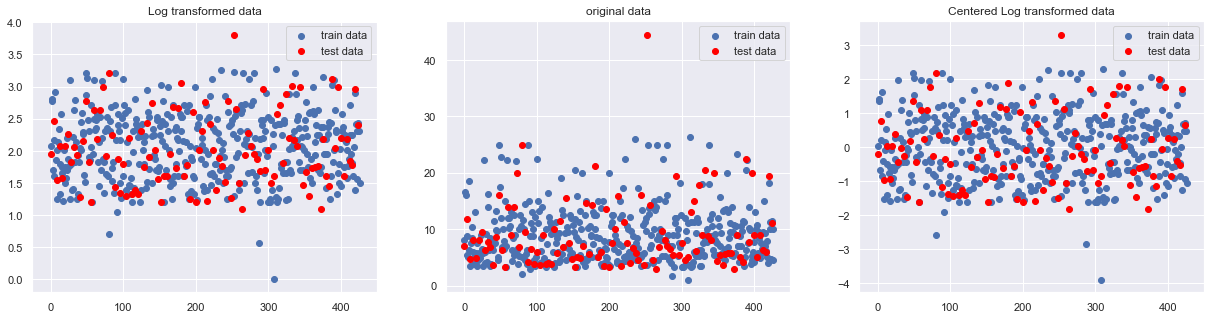

In [6]:
big_plot(21,5)
plt.subplot(132)
plt.scatter(np.arange(len(y)), np.exp(y), label = "train data")
plt.scatter(4*np.arange(len(y_test)), np.exp(y_test), label = "test data", color = "red")
plt.title("original data")
plt.legend()
plt.subplot(131)
plt.scatter(np.arange(len(y)), y, label = "train data")
plt.scatter(4*np.arange(len(y_test)), y_test, label = "test data", color = "red")
plt.title("Log transformed data")
plt.legend()
plt.subplot(133)
plt.scatter(np.arange(len(Y)), Y, label = "train data")
plt.scatter(4*np.arange(len(Y_test)), Y_test, label = "test data", color = "red")
plt.title("Centered Log transformed data")
plt.legend()
plt.show()

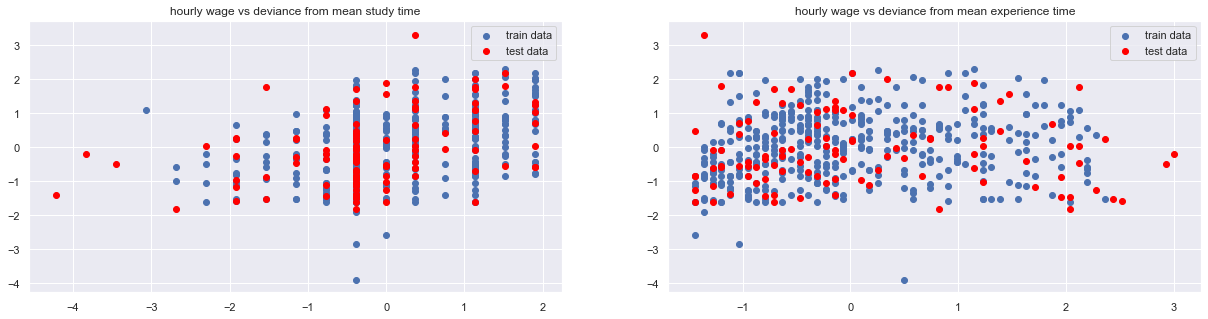

In [7]:
plt.subplot(121)
plt.scatter(X[:,0],Y,label = "train data")
plt.scatter(X_test[:,0],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean study time")
plt.subplot(122)
plt.scatter(X[:,7],Y, label = "train data")
plt.scatter(X_test[:,7],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean experience time")
plt.savefig("results/regressors.png",dpi = 300, bbox_inches = "tight")
plt.show()

# Create the models

`model_gausian`:

- Conditional model:
$$ Y = X\beta + \epsilon$$
$$\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$$

- Priors:
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$
$$\sigma \sim exp(\lambda) \quad \lambda = 2 $$


`model_student`:
    
- conditional model:
$$ Y = X\beta + \epsilon$$


$$\varepsilon_i \sim \text{ Student of degree d }$$


- priors
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$


$$\text{ d } \sim \Gamma(2,4) $$    

In [8]:
model_gaussian = Model.Model(Prior.Gaussian_exp_prior,Conditional_model.Gaussian, Prior = [0,3,2], data = X, response = Y, additional_param = 1)
model_student = Model.Model(Prior.Gaussian_gamma_prior, Conditional_model.Student, Prior = [0,3,2,1/4], data = X, response = Y, additional_param = 1)

## Obtaining estimates of the parameters

## using Laplace approximation with different optimization methods

#### using vanilla gradient descent

Update step:
   $$ \theta_{n+1} = \theta_n - \eta\nabla f(\theta_n)$$

In [9]:
Laplace.laplace_approx(model_gaussian,method =  GD.vanilla_gd)

Progress : [====================] 100% Done...
 early convergence at 3351 iterations  duration: 0:00:07


In [10]:
Laplace.laplace_approx(model_student,method =  GD.vanilla_gd)

Progress : [====================] 100% Done...
   duration: 0:00:23


#### using line search

Update step:
   $$ \theta_{n+1} = \theta_n - \eta\nabla f(\theta_n)$$
additional condition: accept if 
$$f(\theta_{n+1})< f(\theta_n) -\eta\epsilon||\nabla_\theta f(\theta_n)||_2^2$$

In [11]:
Laplace.laplace_approx(model_gaussian,method =  GD.line_search_gd,name_method="line search")

Progress : [====================] 100% Done...
 early convergence at 3582 iterations  duration: 0:00:09


In [12]:
Laplace.laplace_approx(model_student,method =  GD.line_search_gd,name_method="line search")

Progress : [====================] 100% Done...
   duration: 0:00:25


#### using Wolfe condition to adpat the step size

Check the Wolfe condition and adapt the step size accordingly: $p_k = \nabla f(x_k)$,   $ \quad 0<c_1<c_2<1$

if $f(x_k + \alpha_kp_k) \leq f(x_k) + c_1\alpha_kp_k^T\nabla f(x_k)$  then reduce step size $\alpha_k$

if $-p_k^T\nabla f(x_k+\alpha_kp_k) \leq -c_2p_k^T\nabla f(x_k)$ then increase step size 

else accept update

In [13]:
Laplace.laplace_approx(model_gaussian,method =  GD.Wolfe_cond_gd,name_method="Wolfe conditions")

Progress : [====================] 100% Done...
   duration: 0:00:40


In [14]:
Laplace.laplace_approx(model_student,method =  GD.Wolfe_cond_gd,name_method="Wolfe conditions")

Progress : [====================] 100% Done...
   duration: 0:00:53


### Using stochastic gradient descent

In [15]:
Laplace.laplace_approx(model_gaussian,method =  GD.stochastic_gd,name_method="SGD")

Progress : [====================] 100% Done...
   duration: 0:00:18


In [16]:
Laplace.laplace_approx(model_student,method =  GD.stochastic_gd,name_method="SGD")

Progress : [====================] 100% Done...
   duration: 0:00:21


## Using Metropolis Hastings

#### with gaussian random walk

Progress : [====================] 100% Done...
  Acceptance rate : 15.9%  (advised values between 10% and 50%)
  duration: 0:00:24
iterations


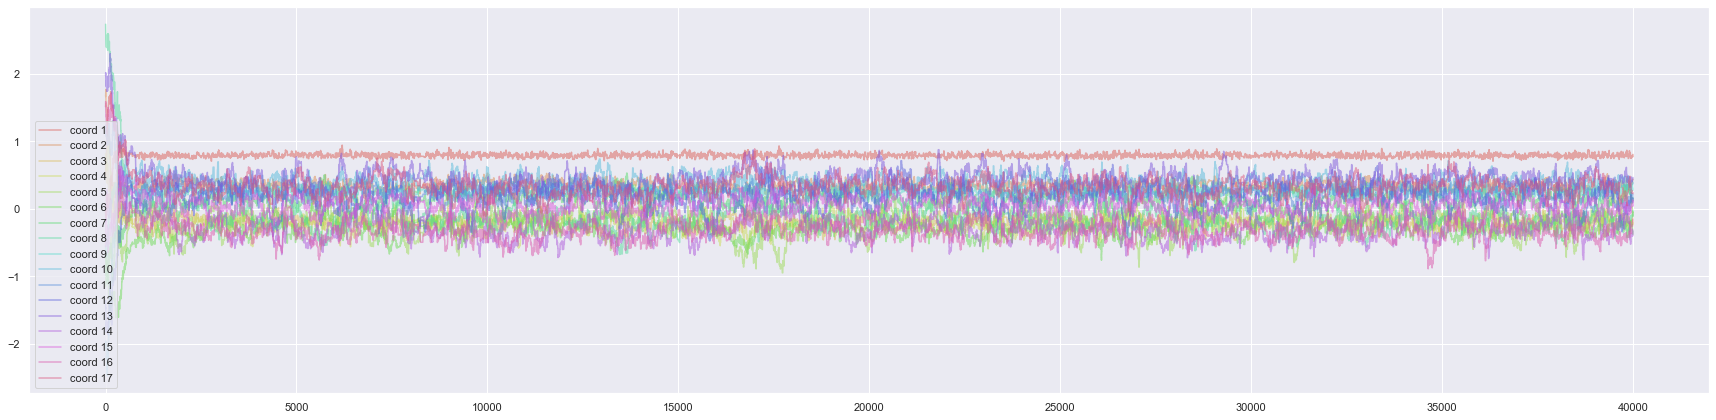

In [17]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    step_size = 0.05*np.ones(model_gaussian.size)
    step_size[0]=0.035
    samples_gaussian_rw = MH.random_walk_MH(model_gaussian, max_iter = 40000, verbose = True, step_size = step_size, initial = initial, RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 40.6%  (advised values between 10% and 50%)
  duration: 0:00:28
iterations


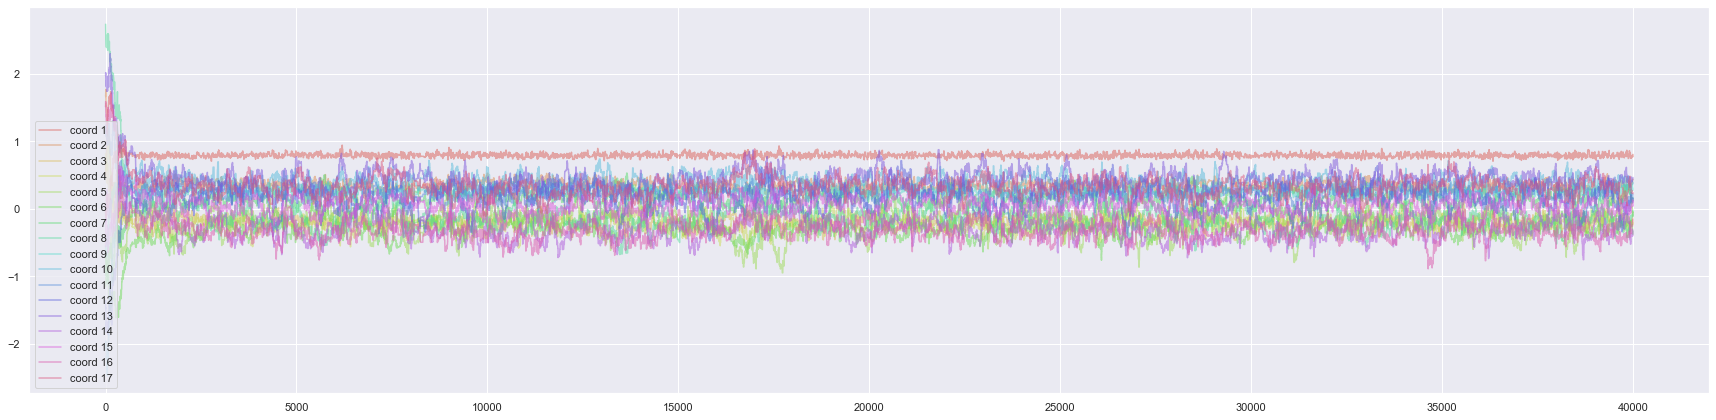

In [18]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]= 20
    step_size = np.ones_like(initial)*0.035
    step_size[0] = 5
    samples_student_rw = MH.random_walk_MH(model_student, max_iter = 40000, verbose = True, step_size = step_size, initial = initial,RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

#### with Langevin correction

Progress : [====================] 100% Done...
  Acceptance rate : 30.8%                 (advised values between 10% and 50%)
  duration: 0:03:05
iterations


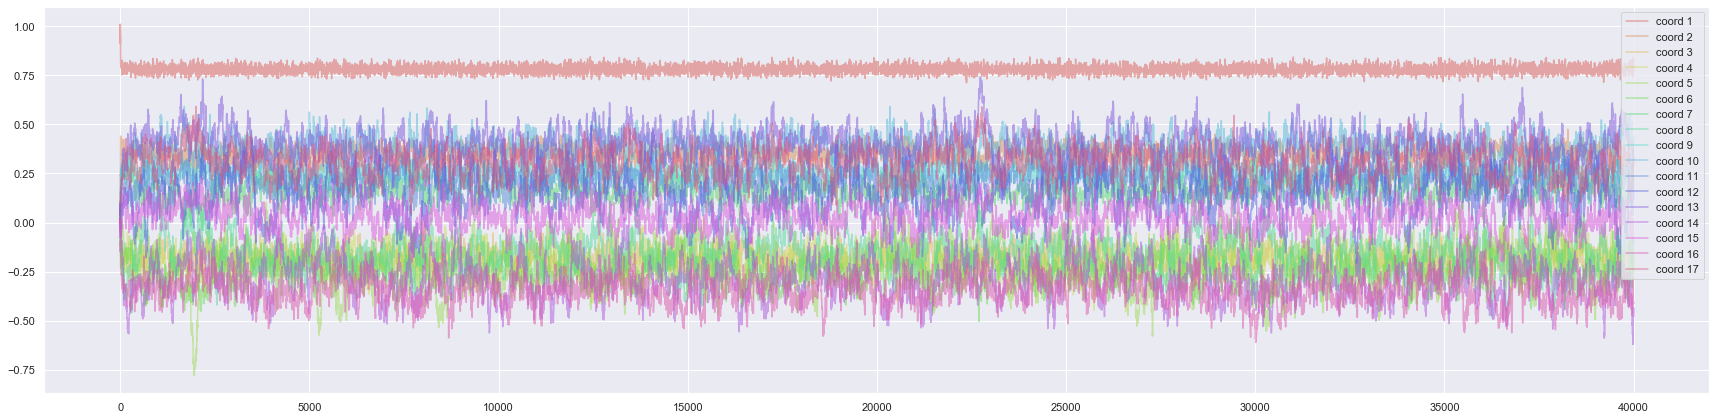

In [19]:
with warnings.catch_warnings(record=True):
    initial = np.zeros(model_gaussian.size)
    initial[0]=1
    samples_gaussian_langevin = MH.Langevin_MH(model_gaussian, max_iter = 40000, initial = initial,verbose = True, tau = 4*1e-4,RETURN=True)
    samples_exploration(samples_gaussian_langevin,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 25.5%                 (advised values between 10% and 50%)
  duration: 0:04:01
iterations


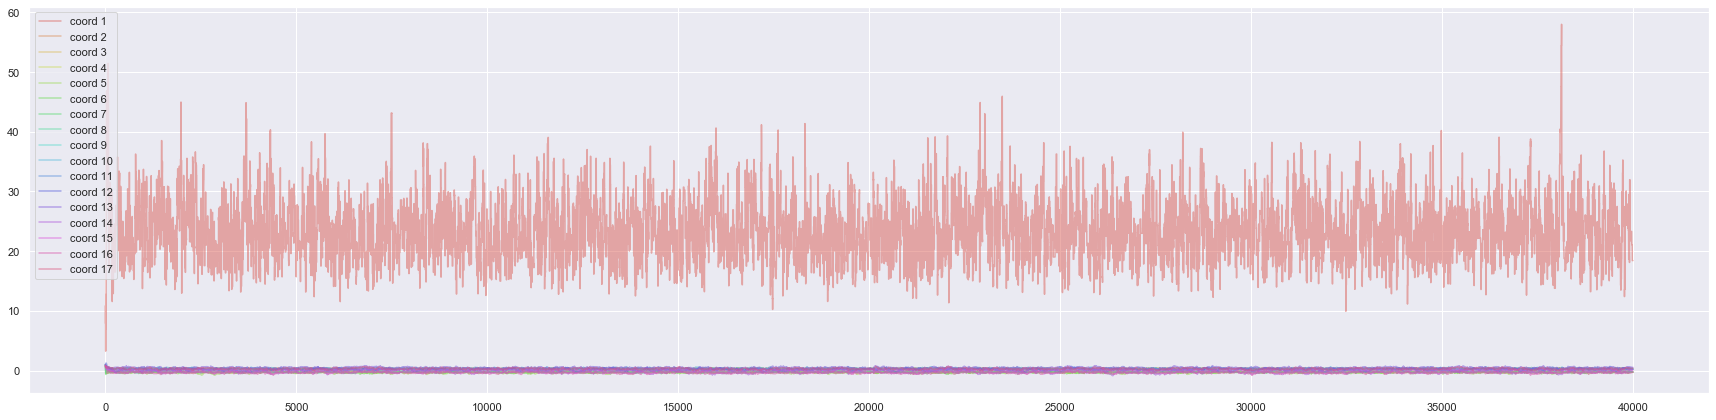

In [20]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_student.size)
    initial[0]=12
    step_size = np.ones(model_student.size)
    step_size[0] = 100
    samples_student_langevin = MH.Langevin_MH(model_student, max_iter = 40000, initial = initial, tau = 1e-3, RETURN=True,step_size = step_size)
    samples_exploration(samples_student_langevin,correlation=False, distribution = False)

#### Using Metropolis Hastings within gibbs

This is done to see if there is any gain in computational time

default batch is 5
Progress : [====================] 100% Done...
  Acceptance rate : 50.1%  (advised values between 10% and 50%)
  duration: 0:00:19
iterations


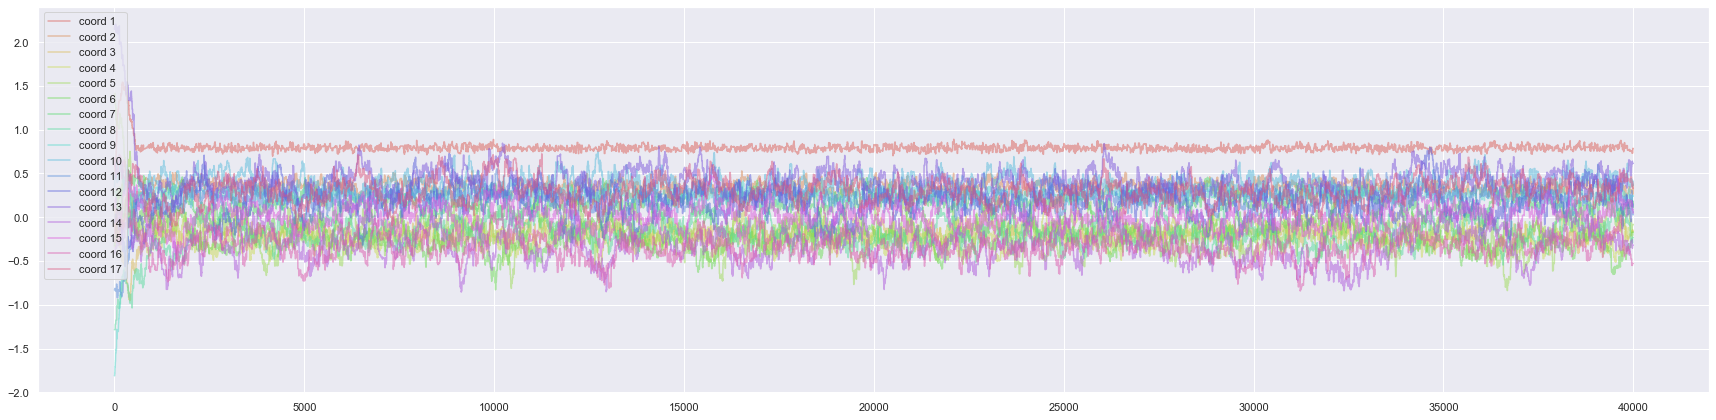

In [21]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    step_size = 0.05*np.ones(model_gaussian.size)
    step_size[0]=0.035
    samples_gaussian_gibbs = MH.MH_whithin_Gibbs(model_gaussian, max_iter = 40000, verbose = True, step_size = step_size, initial = initial, RETURN= True)
    samples_exploration(samples_gaussian_gibbs,correlation=False,distribution=False)

default batch is 5
Progress : [====================] 100% Done...
  Acceptance rate : 59.2%  (advised values between 10% and 50%)
  duration: 0:00:22
iterations


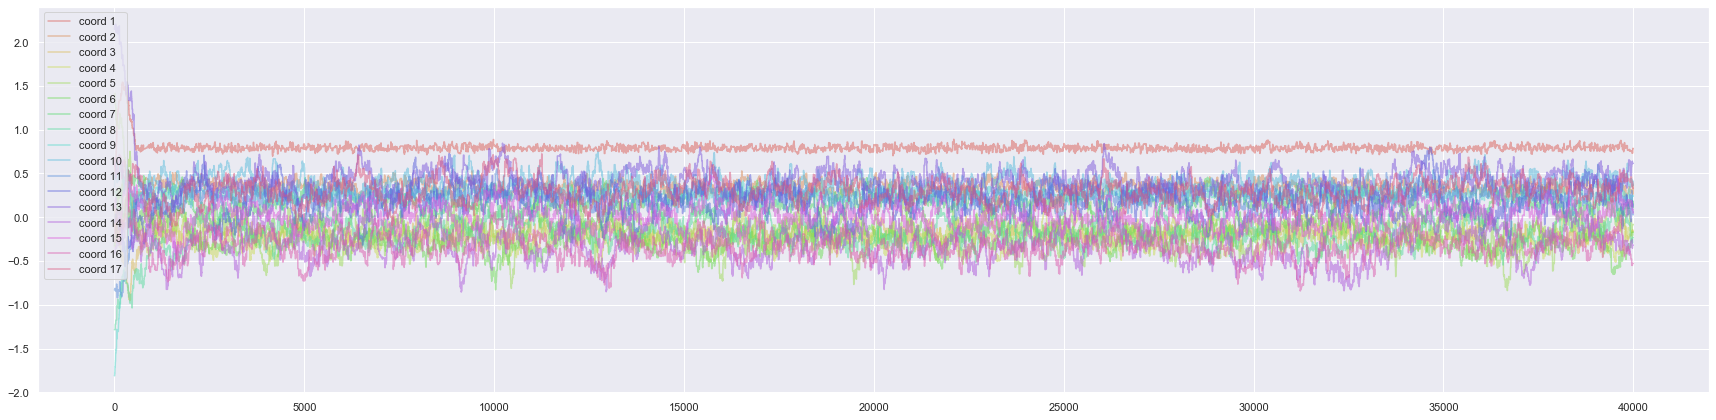

In [22]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]= 20
    step_size = np.ones_like(initial)*0.05
    step_size[0] = 5
    samples_student_gibbs = MH.MH_whithin_Gibbs(model_student, max_iter = 40000, verbose = True, step_size = step_size, initial = initial,RETURN= True)
    samples_exploration(samples_gaussian_gibbs,correlation=False,distribution=False)

### extraction of the estimates from the models

we use point estimates, precisely the mean of the distribution

In [23]:
r_gaussian = model_gaussian()
r_gaussian.T

error         ED     SOUTH     NONWH  \
Laplace with vanilla gd        0.773617  0.351340 -0.185605 -0.205097   
Laplace with line search       0.773618  0.352065 -0.185598 -0.204056   
Laplace with Wolfe conditions  0.793546  0.335745 -0.257839 -0.181027   
Laplace with SGD               0.763748  0.361226 -0.190431 -0.186556   
MH_vanilla                     0.790667  0.347057 -0.190825 -0.212225   
MH_Langevin                    0.780109  0.351691 -0.186400 -0.203375   
MH_Gibbs_mean                  0.790058  0.350581 -0.191436 -0.199435   

                                   HISP        FE      MARR    MARRFE  \
Laplace with vanilla gd       -0.213916 -0.241604  0.168246 -0.159579   
Laplace with line search      -0.211552 -0.236541  0.171699 -0.164864   
Laplace with Wolfe conditions  0.234199 -0.519991 -0.062918  0.093940   
Laplace with SGD              -0.105304 -0.246360  0.168396 -0.159471   
MH_vanilla                    -0.191851 -0.249905  0.164306 -0.158672   
MH_Langevin                   -0.220520 -0.237112  0.171367 -0.162690   
MH_Gibbs_mean                 -0.203592 -0.233409  0.169617 -0.162565   

                                     EX     UNION     MANUF    CONSTR  \
Laplace with vanilla gd        0.258239  0.385944  0.213543  0.142711   
Laplace with line search       0.258291  0.385175  0.211972  0.140721   
Laplace with Wolfe conditions  0.272369  0.393092  0.336011  0.533428   
Laplace with SGD               0.262964  0.390825  0.213949  0.153734   
MH_vanilla                     0.259186  0.383768  0.218432  0.144238   
MH_Langevin                    0.257797  0.383013  0.209736  0.142437   
MH_Gibbs_mean                  0.256572  0.378795  0.213217  0.180144   

                                  MANAG     SALES      CLER      SERV  \
Laplace with vanilla gd        0.395729 -0.295442  0.027576 -0.343370   
Laplace with line search       0.391363 -0.299932  0.023935 -0.346805   
Laplace with Wolfe conditions  0.614766  0.174680  0.260062 -0.099339   
Laplace with SGD               0.383485 -0.277982  0.020896 -0.339199   
MH_vanilla                     0.412762 -0.305764  0.038700 -0.339503   
MH_Langevin                    0.393624 -0.292021  0.024332 -0.345999   
MH_Gibbs_mean                  0.400340 -0.311006  0.015481 -0.349643   

                                   PROF  
Laplace with vanilla gd        0.299739  
Laplace with line search       0.295336  
Laplace with Wolfe conditions  0.533979  
Laplace with SGD               0.283533  
MH_vanilla                     0.319027  
MH_Langevin                    0.296349  
MH_Gibbs_mean                  0.298393

In [24]:
r_student = model_student()
r_student.T

error         ED     SOUTH     NONWH  \
Laplace with vanilla gd         6.722439  0.339458 -0.204339 -0.240557   
Laplace with line search        6.728341  0.339564 -0.204326 -0.240396   
Laplace with Wolfe conditions  10.823977  0.339917 -0.201215 -0.229065   
Laplace with SGD                3.430594  0.338194 -0.215023 -0.243050   
MH_vanilla                     24.470469  0.345493 -0.190936 -0.217120   
MH_Langevin                    23.293408  0.342755 -0.193127 -0.219600   
MH_Gibbs_mean                  24.608632  0.338135 -0.197546 -0.240009   

                                   HISP        FE      MARR    MARRFE  \
Laplace with vanilla gd       -0.297032 -0.265212  0.207080 -0.187814   
Laplace with line search      -0.296749 -0.264465  0.207555 -0.188554   
Laplace with Wolfe conditions -0.276358 -0.257497  0.198861 -0.183202   
Laplace with SGD              -0.180677 -0.363130  0.172625 -0.110013   
MH_vanilla                    -0.305640 -0.218659  0.207705 -0.214097   
MH_Langevin                   -0.259145 -0.245804  0.187486 -0.178787   
MH_Gibbs_mean                 -0.229177 -0.280273  0.163500 -0.149066   

                                     EX     UNION     MANUF    CONSTR  \
Laplace with vanilla gd        0.264378  0.365822  0.205215  0.122515   
Laplace with line search       0.264386  0.365719  0.205005  0.122159   
Laplace with Wolfe conditions  0.262451  0.369417  0.205380  0.125425   
Laplace with SGD               0.274794  0.359563  0.227881  0.168153   
MH_vanilla                     0.261078  0.370470  0.189209  0.086359   
MH_Langevin                    0.259203  0.373919  0.208922  0.141308   
MH_Gibbs_mean                  0.258652  0.402966  0.226578  0.098654   

                                  MANAG     SALES      CLER      SERV  \
Laplace with vanilla gd        0.503462 -0.280501  0.059534 -0.359440   
Laplace with line search       0.502804 -0.281165  0.058991 -0.359930   
Laplace with Wolfe conditions  0.483618 -0.286252  0.050555 -0.355084   
Laplace with SGD               0.559934 -0.166397  0.129155 -0.308975   
MH_vanilla                     0.441259 -0.324159  0.029677 -0.340597   
MH_Langevin                    0.452163 -0.293360  0.039406 -0.356522   
MH_Gibbs_mean                  0.468461 -0.269409  0.065388 -0.315194   

                                   PROF  
Laplace with vanilla gd        0.313068  
Laplace with line search       0.312439  
Laplace with Wolfe conditions  0.311113  
Laplace with SGD               0.362567  
MH_vanilla                     0.287892  
MH_Langevin                    0.307463  
MH_Gibbs_mean                  0.334869

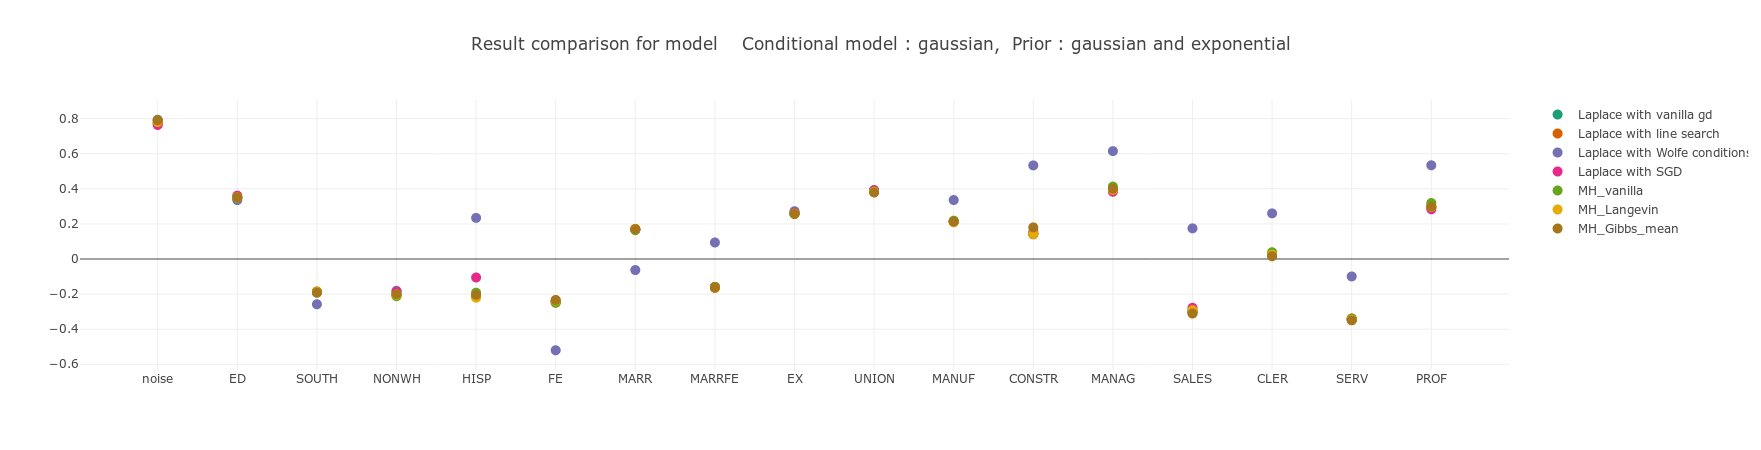

In [25]:
visualisation(r_gaussian,model_gaussian)

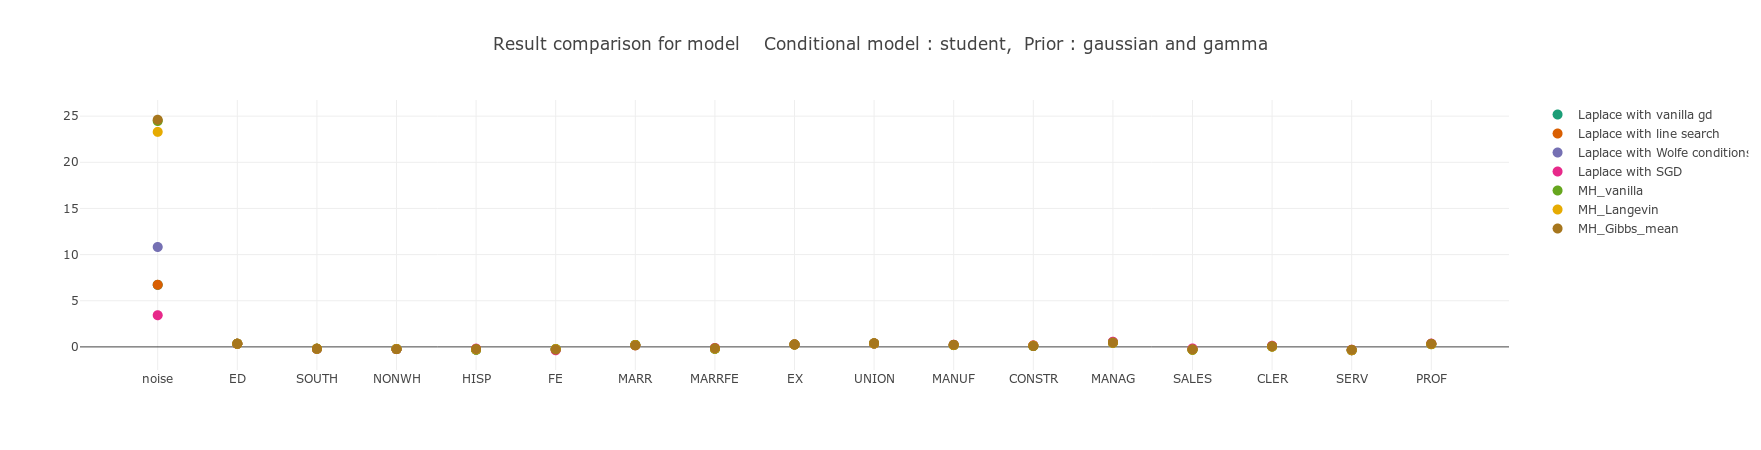

In [26]:
visualisation(r_student,model_student)

## Accuracy of the prediction

In order to predict, we have to use : $$ f(y| D = d) = \int f(y,\theta|D = d)d\theta = \int f(y|\theta)f(\theta|D=d)d\theta$$
Since we suppose our data are iid, the dependence of $y$ to $D$ is only through $\theta$



Supposing we want to approximate $y$ by its mean in the case of our first model, with the gaussian noise, gaussian prior on $\beta$ and exponential prior on $\sigma$:

\begin{align} \mathbb{E}[y|D=d] &= \int y f(y|D=d)dy \\
&= \int y \int f(y|\theta)f(\theta|D=d)d\theta dy \\
&= \int\int y f(y|\theta)f(\theta|D=d)d\theta dy\\
&= \int\left( \int y f(y|\theta)dy \right) f(\theta|D=d)d\theta \\
&= \int x^T\beta f(\theta|D=d)d\theta \\ 
&= \mathbb{E}_{\theta \sim \theta|D=d}[x^T\beta]\\
&= x^T \widehat{\beta}
\end{align}

So supposing we can switch the integrals (using Fubini since both functions are positive (densities) and the integral $\int y f(y|\theta)f(\theta|D=d)d\theta dy $ is finite ), the point prediction can be done by either marginalizing out the $\theta$, or by first finding the "optimal" theta and then predicting the mean of the conditional model. This is logic given that the marginalization of the $\theta$ is there because we do not know the distribution of the $\theta$, but only its distribution. But if we are interested in a point estimate, this inflation in the uncertainty of our precision is not directly usefull.


For our second model, the same development holds.

Otherwise we could just use the samples from the previous run of our Metropolis Hasting algorithms and for each $\theta$ sampled, compute a prediction $x^T\theta$ and then compute a statistic on these. 

When using the samples from Metropolis-Hastings algorithm, we will make a gaussian approximation of our posterior, so the MAP will be the mean or the median. Since this is an approximation, we will use both mean and median to see if there is any discrepancies in our reasonning.

In [27]:
errors_gaussian = pd.DataFrame()
for name in r_gaussian.columns:
    beta = r_gaussian[name].values[1:]
    errors_gaussian[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_gaussian.index = ["error on test","error on train"]
errors_gaussian.T

error on test  error on train
Laplace with vanilla gd             0.685608        0.613739
Laplace with line search            0.685803        0.613792
Laplace with Wolfe conditions       0.681076        0.627020
Laplace with SGD                    0.683704        0.615311
MH_vanilla                          0.684405        0.613713
MH_Langevin                         0.686130        0.613637
MH_Gibbs_mean                       0.686238        0.613429

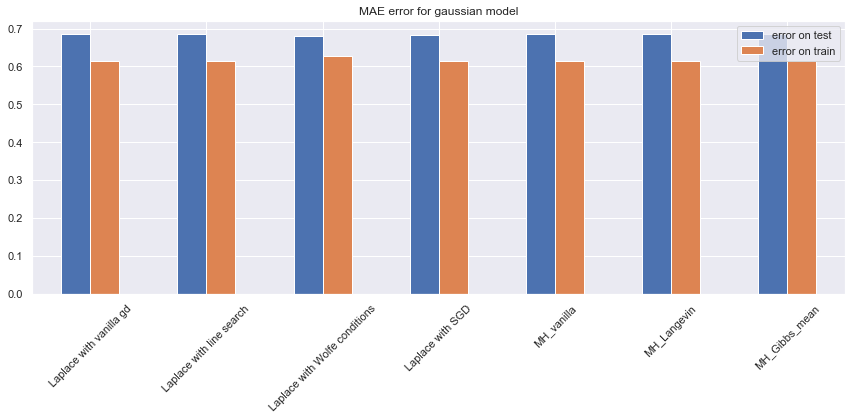

In [28]:
big_plot(12,6)
errors_gaussian.T.plot.bar()
plt.xticks(rotation= 45)
plt.title("MAE error for gaussian model")
plt.tight_layout()
plt.savefig("results/gaussian_accuracy.png", dpi = 300,bbox_inches = "tight")
reset_plot()

In [29]:
errors_student = pd.DataFrame()
for name in r_student.columns:
    beta = r_student[name].values[1:]
    errors_student[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_student.index = ["error on test","error on train"]
errors_student.T

error on test  error on train
Laplace with vanilla gd             0.685281        0.609907
Laplace with line search            0.685319        0.609909
Laplace with Wolfe conditions       0.685170        0.610570
Laplace with SGD                    0.681222        0.609815
MH_vanilla                          0.685614        0.612493
MH_Langevin                         0.685956        0.611316
MH_Gibbs_mean                       0.682401        0.612195

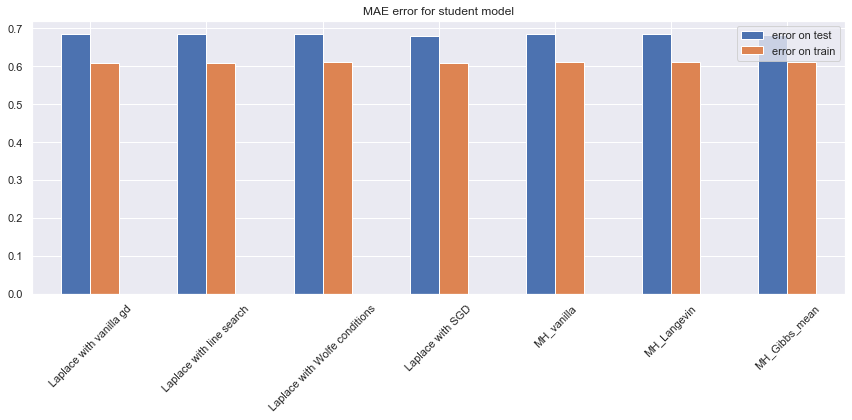

In [30]:
big_plot(12,6)
errors_student.T.plot.bar()
plt.xticks(rotation=45)
plt.title("MAE error for student model")
plt.tight_layout()
plt.savefig("results/student_accuracy.png", dpi = 300,bbox_inches = "tight")
reset_plot()

#### Marginalization of the $\theta$

Example of marginalization of the $\theta$ parameter and taking the MAP estimator on the posterior predictive density

We only do it for the gaussian model since it is quite heavy computationally speaking

In [31]:
from scipy.stats import norm as cheat_norm

In [32]:
samples_gaussian = [samples_gaussian_rw[1000:,], samples_gaussian_langevin[1000:,], samples_gaussian_gibbs[1000:,]]

In [33]:
y_grid = np.arange(-3,3.01,0.1)
scores = []
for S in samples_gaussian:
    y_pred = []
    for i,x_test in enumerate(X_test):
        #only taking the beta
        means = np.dot(S[:,1:],x_test)
        #exctraction of the sigma
        variances = S[:,1]
        s = S.shape[0]
        y_inter = np.repeat(y_grid,s, axis = 0)
        y_inter = y_inter.reshape(len(y_grid),s)
        density = np.mean(cheat_norm.pdf(y_inter, loc = means, scale = variances),axis = 1)
        y_pred.append(np.argmax(density))
    actual_prediction = [y_grid[p] for p in y_pred]
    scores.append(np.sum(np.abs(actual_prediction-Y_test))/len(Y_test))

In [34]:
scores

[0.6850137191278028, 0.6887520368848122, 0.6887520368848122]

This gives the same approximation as in the plots above, confirming our first method

# Classification 

`multilogi`:

- Conditional model
$$\mathbb{P}\left(Y=1|X\right) = \frac{e^{X^T\beta}}{1+e^{X^T\beta}}$$

- Prior:
$$\beta \sim N(0,3^2I) $$

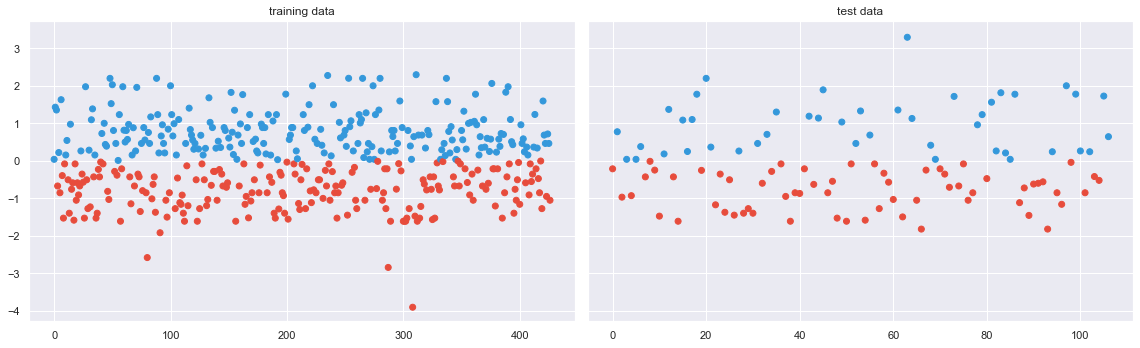

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

inter = Y
classes = inter.copy()
classes[Y >= 0] = 0
classes[Y < 0 ]= 1

#flatui = ["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]

def convert(n): 
    return flatui[int(n)]
colors = list(map(convert, classes) )

axs[0].scatter(np.arange(0,X.shape[0]),Y, c = colors)
axs[0].set_title("training data")


inter = Y_test
classes_test = inter.copy()
classes_test[Y_test >= 0] = 0
classes_test[Y_test < 0 ]= 1
colors = list(map(convert, classes_test) )


axs[1].scatter(np.arange(0,X_test.shape[0]),Y_test, c = colors)
axs[1].set_title("test data")

plt.tight_layout()
plt.show()

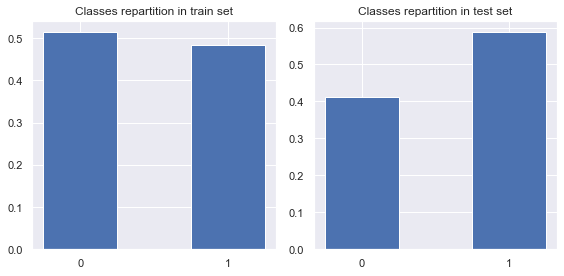

In [36]:
plt.subplot(121)
plt.bar([0.4,0.8],[len(classes[classes==0])/len(classes),len(classes[classes==1])/len(classes)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in train set")
plt.subplot(122)
plt.bar([0.4,0.8],[len(classes_test[classes_test==0])/len(classes_test),len(classes_test[classes_test==1])/len(classes_test)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in test set")
plt.tight_layout()
plt.show()

adding an intercept

In [37]:
X_intercept = np.append(X, np.ones((X.shape[0],1)), axis = 1)
X_intercept_test = np.append(X_test, np.ones((X_test.shape[0],1)), axis = 1)

In [65]:
multilogi = Model.Model(Prior.Gaussian_prior,Conditional_model.Multilogistic,data = X_intercept,response = classes, Prior = [0,3*np.ones(17)],cond_model = [2])

In [66]:
Laplace.laplace_approx(multilogi,method =  GD.vanilla_gd)

Progress : [====================] 100% Done...
   duration: 0:00:07


In [67]:
Laplace.laplace_approx(multilogi,method =  GD.line_search_gd,name_method="line search")

Progress : [====================] 100% Done...
   duration: 0:00:09


In [68]:
Laplace.laplace_approx(multilogi,method =  GD.Wolfe_cond_gd,name_method="Wolfe conditions")

Progress : [====================] 100% Done...
 early convergence at 4357 iterations  duration: 0:00:07


In [69]:
Laplace.laplace_approx(multilogi,method =  GD.stochastic_gd,name_method="SGD")

Progress : [====================] 100% Done...
   duration: 0:00:08


Progress : [====================] 100% Done...
  Acceptance rate : 22.8%  (advised values between 10% and 50%)
  duration: 0:00:17
iterations


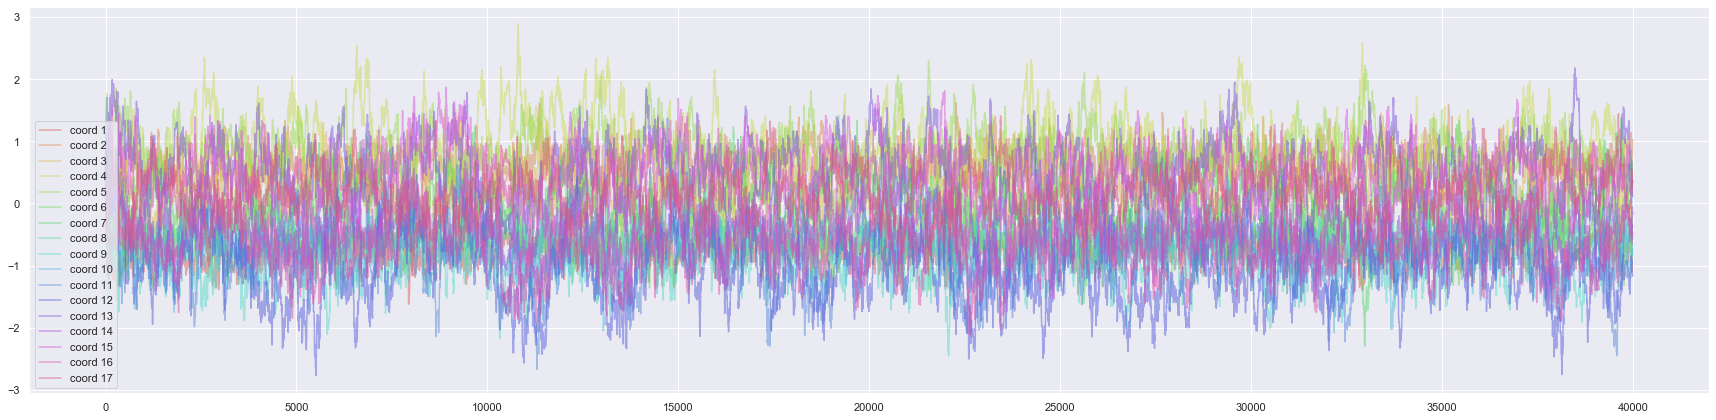

In [75]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_rw = MH.random_walk_MH(multilogi, max_iter = 40000, verbose = True, step_size = 1.3*1e-1, initial = initial, RETURN=True)
    samples_exploration(samples_classification_rw, distribution=False, correlation= False)

Progress : [====================] 100% Done...
  Acceptance rate : 15.7%                 (advised values between 10% and 50%)
  duration: 0:00:58
iterations


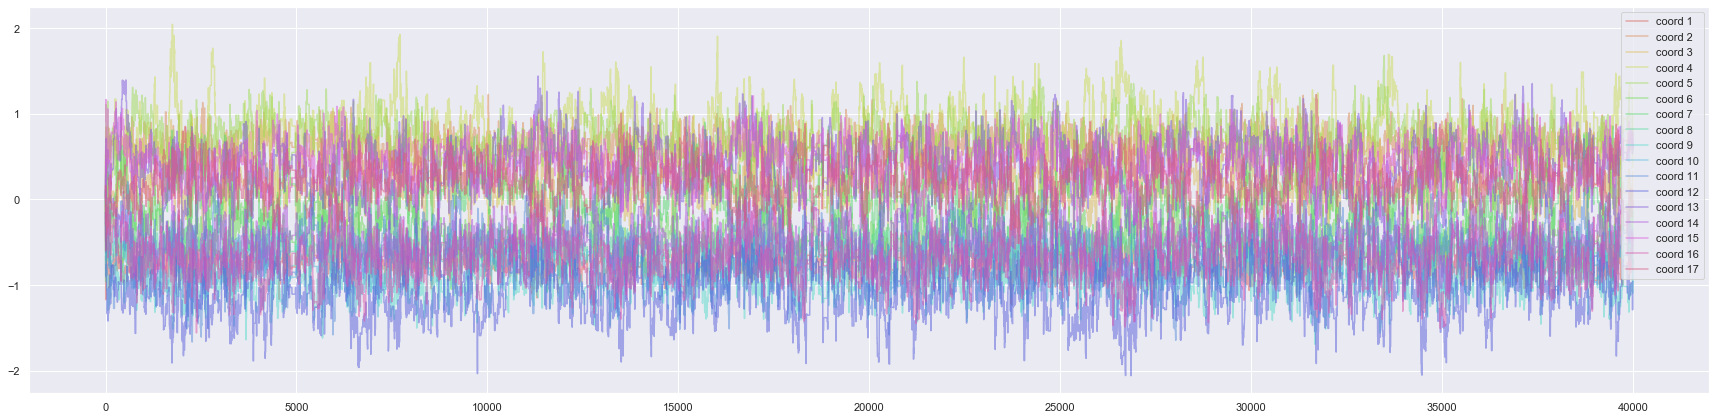

In [71]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.1
    samples_classification_langevin = MH.Langevin_MH(multilogi, max_iter = 40000, verbose = True, initial = initial, tau = 1e-2,RETURN=True)
    samples_exploration(samples_classification_langevin, distribution=False, correlation= False)

default batch is 5
Progress : [====================] 100% Done...
  Acceptance rate : 39.1%  (advised values between 10% and 50%)
  duration: 0:00:18
iterations


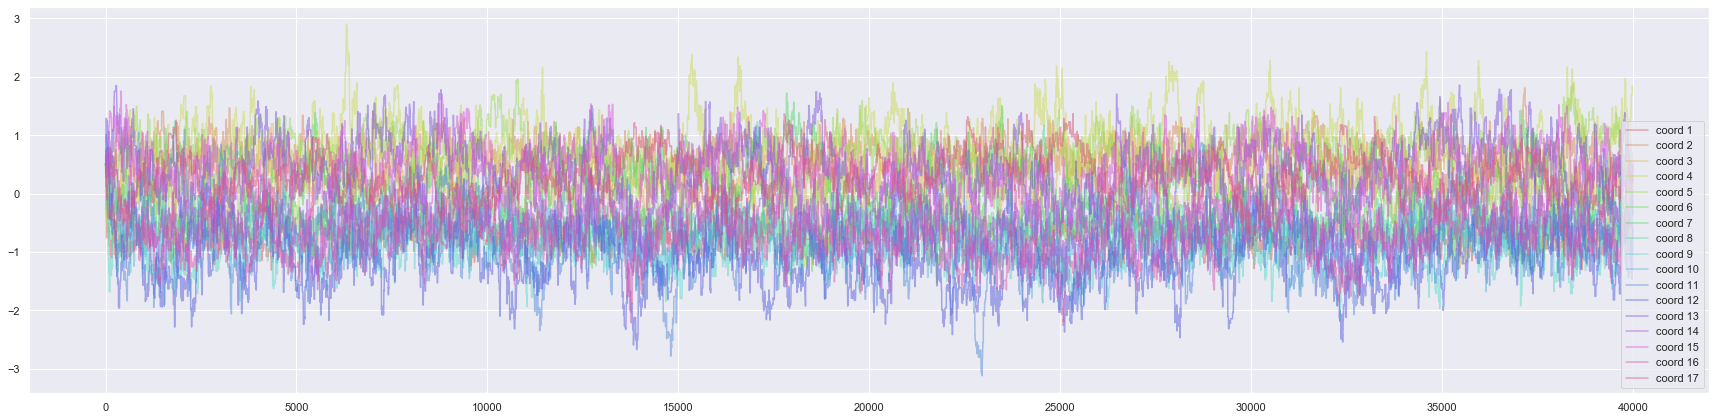

In [74]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_gibbs = MH.MH_whithin_Gibbs(multilogi, max_iter = 40000, verbose = True, step_size = 2*1e-1, initial = initial, RETURN=True)
    samples_exploration(samples_classification_gibbs, distribution=False, correlation= False)

In [76]:
r_multilogi = multilogi()
r_multilogi.T

error         ED     SOUTH     NONWH  \
Laplace with vanilla gd       -0.721984  0.615777  0.178508  0.643838   
Laplace with line search      -0.732620  0.627818  0.142590  0.458023   
Laplace with Wolfe conditions -0.729277  0.615070  0.172639  0.725618   
Laplace with SGD              -0.738490  0.647697  0.339689  0.518850   
MH_vanilla                    -0.763514  0.659736  0.193522  0.827054   
MH_Langevin                   -0.738893  0.629210  0.159161  0.749282   
MH_Gibbs_mean                 -0.752635  0.639207  0.165453  0.757012   

                                   HISP        FE      MARR    MARRFE  \
Laplace with vanilla gd        0.738240 -0.332304 -0.067041 -0.549385   
Laplace with line search       0.615340 -0.418496  0.077581 -0.544875   
Laplace with Wolfe conditions  0.667830 -0.373298  0.002855 -0.545639   
Laplace with SGD               0.430298 -0.590552  0.224538 -0.538641   
MH_vanilla                     0.719682 -0.359926 -0.021193 -0.577227   
MH_Langevin                    0.652497 -0.409701  0.050400 -0.549691   
MH_Gibbs_mean                  0.597191 -0.461887  0.117477 -0.559692   

                                     EX     UNION     MANUF    CONSTR  \
Laplace with vanilla gd       -0.908517 -0.709149 -0.485034 -1.078783   
Laplace with line search      -0.899615 -0.729152 -0.644713 -1.047902   
Laplace with Wolfe conditions -0.904378 -0.705753 -0.553115 -1.055339   
Laplace with SGD              -0.506028 -0.022570  0.525104 -0.049421   
MH_vanilla                    -0.963394 -0.737295 -0.611496 -1.131435   
MH_Langevin                   -0.931174 -0.734010 -0.591593 -1.096590   
MH_Gibbs_mean                 -0.952725 -0.792143 -0.686540 -1.137146   

                                  MANAG     SALES      CLER      SERV  \
Laplace with vanilla gd        0.389324 -0.452892  0.417597 -0.680805   
Laplace with line search       0.388896 -0.444519  0.412449 -0.648964   
Laplace with Wolfe conditions  0.429124 -0.431663  0.433063 -0.649490   
Laplace with SGD               0.401730  0.292302  0.778556 -0.006734   
MH_vanilla                     0.461362 -0.461859  0.453864 -0.688895   
MH_Langevin                    0.415812 -0.469628  0.419414 -0.689907   
MH_Gibbs_mean                  0.449681 -0.494675  0.401576 -0.715441   

                                   PROF  
Laplace with vanilla gd        0.159609  
Laplace with line search       0.238454  
Laplace with Wolfe conditions  0.180688  
Laplace with SGD              -0.334930  
MH_vanilla                     0.166058  
MH_Langevin                    0.231574  
MH_Gibbs_mean                  0.298006

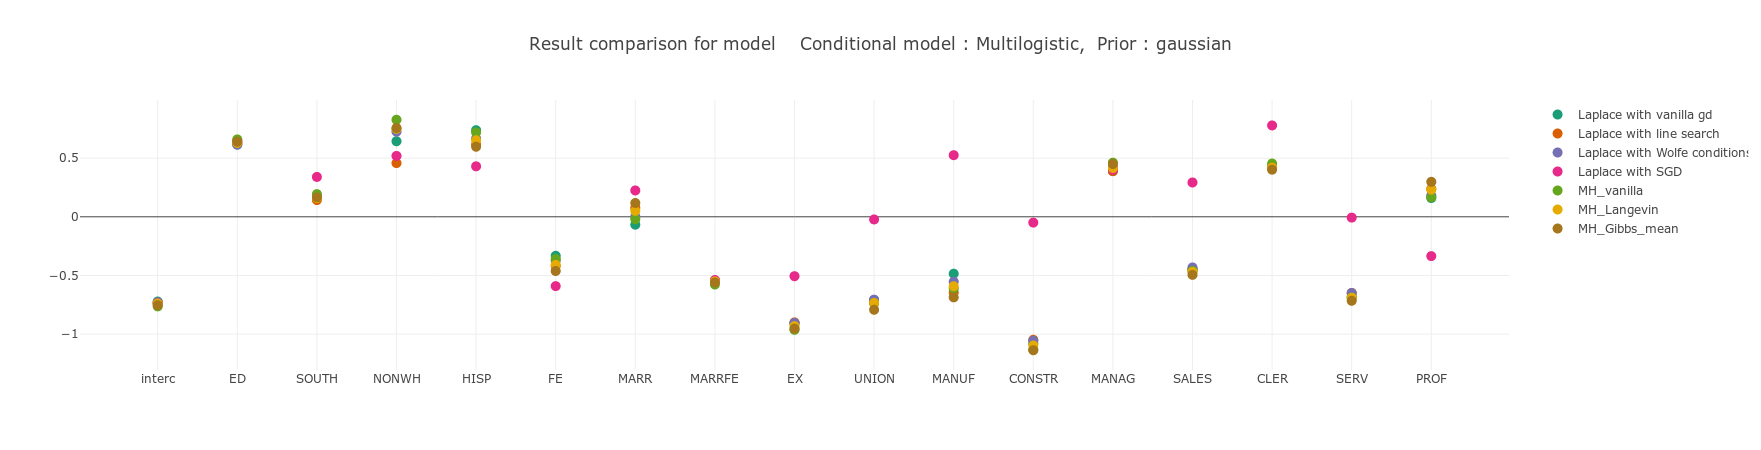

In [77]:
visualisation(r_multilogi,multilogi)

## Results of logistic regression

In order to predict, we will minimize the misclassification error, which mean we will use the decision boundary $\mathbb{P}[Y=1|x]>=0.5$.

Following Bishop _Pattern recognition and Machine learning_, p.220, we first compute the MAP of our parameter $\beta$, and then use it to predict our classes using the decisin boundary above.

In [78]:
predictions = multilogi.predict(X_intercept_test)
fitted = multilogi.predict(X_intercept)

In [79]:
errors = {}

In [80]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes_test):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes_test))
    else:
        errors[name] = [error/len(classes_test)]

In [81]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes))
    else:
        errors[name] = [error/len(classes)]

In [82]:
errors = pd.DataFrame(errors)
errors.index = ["error on test", "error on train"]
errors.T

error on test  error on train
Laplace with vanilla gd             0.271028        0.119438
Laplace with line search            0.271028        0.124122
Laplace with Wolfe conditions       0.280374        0.121780
Laplace with SGD                    0.289720        0.128806
MH_vanilla                          0.280374        0.121780
MH_Langevin                         0.280374        0.121780
MH_Gibbs_mean                       0.280374        0.121780

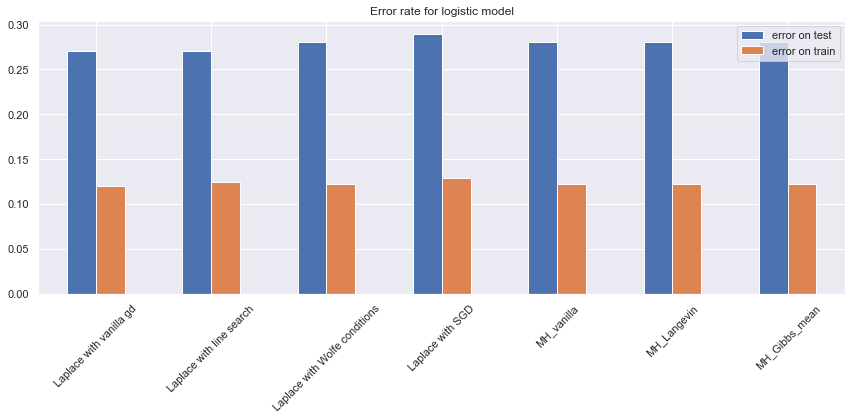

In [83]:
big_plot(12,6)
errors.T.plot.bar()
plt.xticks(rotation=45)
plt.title("Error rate for logistic model")
plt.tight_layout()
plt.savefig("results/logistic_accuracy.png", dpi = 300,bbox_inches = "tight")
reset_plot()

In [84]:
# by simulation using the samples above:
samples = [samples_classification_gibbs[1000:,],samples_classification_langevin[1000:,],samples_classification_rw[1000:,]]
names = ["gibbs","langevn","vanilla MH"]

df_result_sampled = {}


def link(x,theta):
    return np.dot(x,theta)

for i,S in enumerate(samples):
    error_rate = 0
    for x,y in zip(X_intercept_test,classes_test):
        expo = link(x,S.T)
        proba = np.exp(expo)/(1+np.exp(expo))
        if np.sum(proba >=0.5)>np.sum(proba < 0.5):
            predict = 1
        else:
            predict = 0
        if predict != y:
            error_rate +=1 
    if i == 0:
        df_result_sampled["test"] = [error_rate/len(classes_test)]
    else:
         df_result_sampled["test"].append(error_rate/len(classes_test))

In [85]:
df_result_sampled

{'test': [0.2803738317757009, 0.2803738317757009, 0.27102803738317754]}

So both gives the same results, but the first one is quicker 

# Comparison of time efficiency of the methods

In [86]:
models = [model_gaussian,model_student,multilogi]

In [87]:
dic_time = {}
dic_time_per_iter = {}
for m in models:
    for key,elt in m.time.items():
        if key in dic_time:
            dic_time[key].append(elt[0])
            dic_time_per_iter[key].append(elt[0]/elt[1])
        else:
            dic_time[key]=[elt[0]]
            dic_time_per_iter[key]=[elt[0]/elt[1]]


In [88]:
df_time = pd.DataFrame(dic_time)
df_time_per_iter = pd.DataFrame(dic_time_per_iter)
df_time.index = ["gaussian","student","logistic"]
df_time_per_iter.index = ["gaussian","student","logistic"]

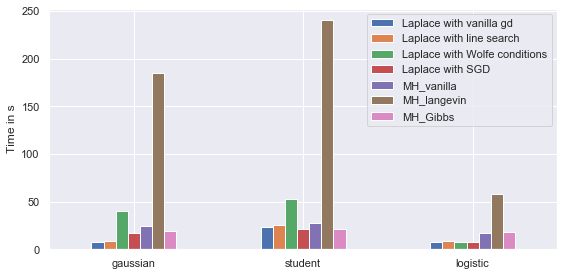

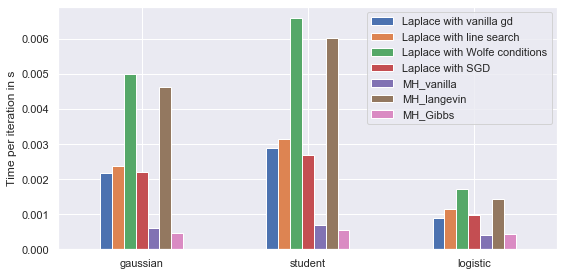

In [89]:
df_time.plot.bar()
plt.xticks(rotation="horizontal")
plt.ylabel("Time in s")
plt.tight_layout()
plt.savefig("results/time.png", dpi = 300,bbox_inches = "tight")
df_time_per_iter.plot.bar()
plt.xticks(rotation="horizontal")
plt.ylabel("Time per iteration in s")
plt.tight_layout()
plt.savefig("results/time_per_iter.png", dpi = 300,bbox_inches = "tight")